In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# 1. Carga de los datos

In [3]:
import os 
ruta = os.getcwd()
print(ruta)

/Users/duman/Documents/universidad/7semestre/BI/BI-202302/Lab2


In [87]:
df_laptops_train = pd.read_csv('./data/laptop_data_train.csv', sep=',', encoding='utf-8')

In [88]:
df_laptops_train.shape

(1216, 14)

In [89]:
df_laptops_train.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
269,423,Asus,Notebook,8,2.30,10.367478,0,0,141.211998,Intel Core i3,1000.0,0,Nvidia,Others
247,263,Dell,Notebook,4,2.18,10.463245,0,0,141.211998,Intel Core i5,1000.0,0,Intel,Windows
739,1067,Dell,2 in 1 Convertible,8,1.62,10.657682,1,0,165.632118,Intel Core i7,0.0,256,Intel,Windows
438,321,Lenovo,Notebook,4,2.79,10.353987,0,0,106.113062,Intel Core i5,1000.0,0,Nvidia,Windows
276,627,Lenovo,Notebook,4,2.20,10.124029,0,0,141.211998,Intel Core i5,0.0,128,Intel,Others


In [90]:
df_laptops_unlabeled = pd.read_csv('./data/laptop_data_test_unlabeled.csv', sep=',', encoding='utf-8')

In [91]:
df_laptops_unlabeled.shape

(64, 14)

In [92]:
df_laptops_unlabeled.sample(5)

,id,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os,CalculatedPrice
15,522,Dell,Notebook,8,NaN,0,0,7532.205590,Intel Core i5,0.0,256,Intel,Windows,NaN
11,568,Lenovo,Notebook,4,2.20,0,0,141.211998,Other Intel Processor,500.0,0,Intel,Windows,NaN
40,438,Lenovo,Ultrabook,24,1.32,0,0,209.800683,Intel Core i7,0.0,512,Intel,Windows,NaN
4,739,Acer,Notebook,4,2.40,0,0,100.454670,Intel Core i3,500.0,0,Intel,Windows,NaN
10,702,Lenovo,Notebook,8,2.20,0,0,100.454670,AMD Processor,1000.0,0,AMD,Windows,NaN


# 2. Entendimiento y limpieza de los datos

In [93]:
# Eleccion de variables relevantes para calcular el precio de un computador
features = [
    'Company',
    'TypeName',
    'Ram',
    'Weight',
    'TouchScreen',
    'Ips',
    'Ppi',
    'Cpu_brand',
    'HDD',
    'SSD',
    'Gpu_brand',
    'Os'
]
featuresCategoricas = ['Company', 'TypeName', 'TouchScreen', 'Ips', 'Cpu_brand', 'Gpu_brand', 'Os']
featuresNumericas = ['Ram', 'Weight', 'Ppi', 'HDD', 'SSD']

### 2.1. Verificacion de atributos de calidad de datos

#### Consistencia: Valores únicos en las variables categóricas

In [94]:
# verificar valores unicos en cada variable categorica
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation' '2 in 1 Convertible%%' 'Gaming%%' '&&Notebook'
 '&&Ultrabook' 'Notebook%%' '&&Gaming' '&&2 in 1 Convertible']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD' 'Intel%%' 'Nvidia%%' '&&Intel' '&&Nvidia' 'AMD%%'
 '&&AMD']
Os: ['Others' 'Windows' 'Mac']


**Resultados:** Se puede observar que las variables 'TypeName' y 'Gpu_brand' tienen valores con caracteres extraños. Se procederá a eliminarlos para corregir esta información.

In [95]:
# Eliminar caracteres "&&", "%%", en las variables categoricas 'TypeName' y 'Gpu_brand'
df_laptops_train['TypeName'] = df_laptops_train['TypeName'].str.replace('&&', '').str.replace('%%', '')
df_laptops_train['Gpu_brand'] = df_laptops_train['Gpu_brand'].str.replace('%%', '').str.replace('&&', '')


In [96]:
#Verificación de valores unicos en cada variable categorica luego de eliminar caracteres "&&", "%%"
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Os: ['Others' 'Windows' 'Mac']


Se corrigieron los valores con caracteres extraños.

#### Completitud: Revisar valores nulos

In [97]:
# Revisión del porcentaje de valores nulos (vacíos) en cada columna

df_laptops_train[['Price']+ features].isnull().sum() / df_laptops_train.shape[0]

Price          0.012336
Company        0.000000
TypeName       0.000000
Ram            0.000000
Weight         0.018914
TouchScreen    0.000000
Ips            0.000000
Ppi            0.009868
Cpu_brand      0.000000
HDD            0.013158
SSD            0.000000
Gpu_brand      0.000000
Os             0.000000
dtype: float64

In [98]:
# Eliminar entradas con datos vacíos
# Antes de realizar el drop, se genera un informe con los datos que se van a eliminar
# .isnull() es igual a .isna()
entradas_a_eliminar = df_laptops_train[df_laptops_train[['Price']+ features].isna().any(axis=1)]
entradas_a_eliminar.to_csv('./data/entradas_a_eliminar.csv', sep=',', encoding='utf-8', index=False)

#conocer entradas eliminadas
entradas_a_eliminar.shape

(46, 14)

In [99]:
# Eliminar entradas con datos vacíos
df_laptops_train = df_laptops_train.dropna(subset=['Price']+ features)
df_laptops_test_unlabeled = df_laptops_unlabeled.dropna(subset=features)

In [100]:
df_laptops_train.shape

(1170, 14)

In [101]:
df_laptops_test_unlabeled.shape

(63, 14)

In [102]:
# Revisión del porcentaje de valores nulos (vacíos) en cada columna luego de eliminar entradas con datos vacíos
df_laptops_train[['Price']+ features].isnull().sum() / df_laptops_train.shape[0]

Price          0.0
Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

In [103]:
# Revision del porcentaje de valores nulos (vacíos) en cada columna luego de eliminar entradas con datos vacíos en datos unlabeled
df_laptops_test_unlabeled[features].isnull().sum() / df_laptops_test_unlabeled.shape[0]

Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

#### Unicidad: Entradas iguales en todas sus variables

In [104]:
# Unicidad de los datos de entrenamiento
entradas_duplicadas_train = df_laptops_train[df_laptops_train.duplicated()]
len(entradas_duplicadas_train)

4

In [105]:
# Unicidad de los datos no etiquetados
entradas_duplicadas_unlabeled = df_laptops_test_unlabeled[df_laptops_test_unlabeled.duplicated()]
len(entradas_duplicadas_unlabeled)

0

In [106]:
# Eliminar entradas duplicadas en datos de entrenamiento. 
# No se encontraron duplicados en datos unlabeled
df_laptops_train = df_laptops_train.drop_duplicates()


In [107]:
# Revisión de entradas duplicadas luego de eliminarlas
entradas_duplicadas = df_laptops_train[df_laptops_train.duplicated()]
len(entradas_duplicadas)

0

#### Validez: Rango lógico y formato correcto de valores en variables numéricas

In [108]:
# Revisar la validez de los datos de las variables numericas y la variable price en el dataset de entrenamiento
df_laptops_train[featuresNumericas + ['Price']].describe()


,Ram,Weight,Ppi,HDD,SSD,Price
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.132753,151.778302,414.802744,187.989708,12.385126
std,5.136040,2.882080,181.493944,517.624081,187.302367,24.476793
min,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,4.000000,1.500000,127.335675,0.000000,0.000000,10.402328
50%,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,8.000000,2.310000,157.350512,1000.000000,256.000000,11.288115
max,64.000000,97.729949,6170.032609,2000.000000,1024.000000,499.766079


Encontramos valores atípicos para las variables Weight y Ppi. Procedemos a reemplazarlos por la mediana.

In [111]:
# Revisamos la cantidad de valores atípicos que tiene la variable Ppi, estos son los mayores a 400. 
df_valores_atipicos_ppi = df_laptops_train[df_laptops_train['Ppi'] > 400]
df_valores_atipicos_ppi

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os


In [112]:
# Los reemplazamos con la mediana
df_laptops_train.loc[df_laptops_train['Ppi'] > 400, 'Ppi'] = df_laptops_train['Ppi'].median()

In [113]:
# Volvemos a revisar la cantidad de valores atípicos que tiene la variable Ppi, estos son los mayores a 400.
df_valores_atipicos_ppi = df_laptops_train[df_laptops_train['Ppi'] > 400]
len(df_valores_atipicos_ppi)

0

In [115]:
# Mismo proceso con la variabale Weight
df_valores_atipicos_weight = df_laptops_train[df_laptops_train['Weight'] > 5]
df_valores_atipicos_weight

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
633,162,Dell,Notebook,8,97.729949,10.565862,0,0,141.211998,Intel Core i5,0.0,256,AMD,Windows


In [118]:
# Reemplazamos los valores atípicos con la mediana
df_laptops_train.loc[df_laptops_train['Weight'] > 5, 'Weight'] = df_laptops_train['Weight'].median()
# Volvemos a revisar la cantidad de valores atípicos que tiene la variable Weight, estos son los mayores a 5.
len(df_laptops_train[df_laptops_train['Weight'] > 5])

0

In [119]:
# Ahora el mismo proceso con los datos en el archivo unlabeled
df_laptops_test_unlabeled[featuresNumericas].describe()

,Ram,Weight,Ppi,HDD,SSD
count,63.000000,63.000000,63.000000,63.000000,63.000000
mean,8.507937,2.002857,154.883423,500.000000,164.190476
std,5.423584,0.618170,51.980062,575.017531,184.184240
min,2.000000,0.690000,90.583402,0.000000,0.000000
25%,4.000000,1.550000,127.335675,0.000000,0.000000
50%,8.000000,2.020000,141.211998,0.000000,128.000000
75%,8.000000,2.265000,161.491315,1000.000000,256.000000
max,32.000000,4.300000,316.965060,2000.000000,1000.000000


In [120]:
# Reemplazamos los valores atipicos con la mediana
df_laptops_test_unlabeled.loc[df_laptops_test_unlabeled['Ppi'] > 400, 'Ppi'] = df_laptops_test_unlabeled['Ppi'].median()

Volvemos a comprobar los datos de las variables numericas y la variable price para comprobar que no hayan valores atipicos


In [122]:
df_laptops_train[featuresNumericas + ['Price']].describe()

,Ram,Weight,Ppi,HDD,SSD,Price
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.050686,146.607787,414.802744,187.989708,12.385126
std,5.136040,0.674661,42.705848,517.624081,187.302367,24.476793
min,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,4.000000,1.500000,127.335675,0.000000,0.000000,10.402328
50%,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,8.000000,2.310000,157.350512,1000.000000,256.000000,11.288115
max,64.000000,4.700000,352.465147,2000.000000,1024.000000,499.766079


In [123]:
df_laptops_test_unlabeled[featuresNumericas].describe()

,Ram,Weight,Ppi,HDD,SSD
count,63.000000,63.000000,63.000000,63.000000,63.000000
mean,8.507937,2.002857,154.883423,500.000000,164.190476
std,5.423584,0.618170,51.980062,575.017531,184.184240
min,2.000000,0.690000,90.583402,0.000000,0.000000
25%,4.000000,1.550000,127.335675,0.000000,0.000000
50%,8.000000,2.020000,141.211998,0.000000,128.000000
75%,8.000000,2.265000,161.491315,1000.000000,256.000000
max,32.000000,4.300000,316.965060,2000.000000,1000.000000


### Output del archivo actual

In [124]:
nombre_archivo = 'df_laptops_train_output1.csv'
df_laptops_train.to_csv('./data/' + nombre_archivo, sep=',', encoding='utf-8', index=False)
nombre_archivo_unlabeled = 'df_laptops_test_unlabeled_output1.csv'
df_laptops_test_unlabeled.to_csv('./data/' + nombre_archivo_unlabeled, sep=',', encoding='utf-8', index=False)

#####

### 2.1. Búsqueda de relaciones entre variables

In [44]:
# Correlacion

correlation_matrix = df_laptops_train[featuresNumericas + ['Price']].corr()
correlation_with_price = correlation_matrix['Price'].sort_values(ascending=False)
correlation_with_price


Price    1.000000
SSD      0.080738
Ram      0.030664
Ppi      0.009436
HDD     -0.030513
Name: Price, dtype: float64

<Axes: >

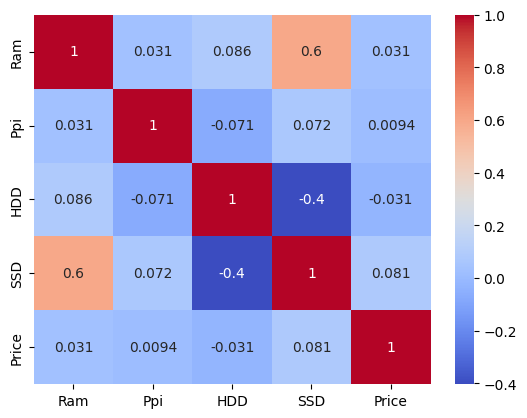

In [45]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')